# Voorwoord en opdracht
Hoe ontsluit je data en verwerk je het tot bruikbare inzichten? Python biedt heel veel mogelijkheden 
om data te ontsluiten, te prepareren en te analyseren. Aan al deze mogelijkheden heb je alleen wat als 
je ze ook echt toe kunt passen. Aan jou de opdracht om de technieken die je tijdens de colleges hebt 
geleerd in de praktijk te brengen. Dit doe je door een eigen dataproject uit te voeren: zelf relevante 
data zoeken en inladen, deze data opschonen en combineren tot relevante inzichten.  

## Beoordeling 
We zijn daarom op zoek naar een originele toepassing waarmee je de inhoud van de college kan 
vertalen in goed werkende en netjes gedocumenteerde python code. De specifieke scores en weging 
van deze criteria kun je op de volgende pagina vinden. 


| **Originaliteit** | **Inhoud** | **Code**| **Documentatie**|
|---|---|---|---|
| Het project omvat een unieke toepassing die in college niet aan bod is gekomen en de student weet hiermee perfect gebruik te maken van de kracht van python. | Alle data-analysestappen worden doorlopen Hierbij wordt aandacht geschonken aan alle geleerde onderwerpen. Geleerde packages worden verrijkt met code uit meerdere andere bronnen | De gehele code werkt en geeft de juiste resultaten weer. Fouten worden automatisch en correct afgehandeld. De code is volledig modulair en werkt met minimale aanpassingen ook op andere datasets. | De code, documentatie en bijpassende titels en teksten maken van het project een duidelijk geheel dat door anderen zonder verdere uitleg zou kunnen worden begrepen |
## Deadline 
We ontvangen je project graag uiterlijk 1 februari, voor (14:00) via Canvas. Mocht je project tot een 
onvoldoende beoordeling leiden, dan heb je nog een keer de kans om een herkansing in te leveren. 
Het is je eigen verantwoordelijkheid om op tijd met je project te starten, we zullen tussendoor dus niet 
controleren hoe ver je bent of gedeeltelijke projecten beoordelen. 
Tijdens het laatste college vragen we je om collega studenten een korte presentatie te geven over je 
project. Die presentatie wordt zelf niet beoordeeld maar geeft je wel de kans om te laten zien hoe je 
met criteria zoals originaliteit of onvoorziene tegenslagen bent omgegaan.   
We raden je aan om de code in Jupyter notebooks te schrijven, maar het staat je vrij om daar een 
ander programma voor te kiezen zolang wij aan het eind van het project de code en resultaten kunnen 
beoordelen.  

## Onderwerp 
Omdat we het leuk vinden als je de geleerde python vaardigheden meteen in de praktijk kan 
toepassen, willen we je vragen om zelf een onderwerp te kiezen. Tijdens de colleges zullen we een 
aantal voorbeelden geven van eerdere projecten. 
Mocht je nog vragen hebben over het project dan kun je je vragen het best stellen op de Canvas-
cursuspagina. Natuurlijk kun je ons ook altijd mailen of tijdens het college aanspreken.

## Wat moet er aan de pas komen

### Masterclass 0
- ~~Variables~~
- ~~Calculations / Arithmetics~~
- Statements & Expressions
- Datatypes
- Operators

### Masterclass 1
- if, else and elif-statements
- One-line if-statements
- Conditional expression
- ~~While-loop~~
- ~~For-loop~~

### Masterclass 2
- ~~functions, parameters and arguments~~
- ~~docstrings~~
- classes (niet verplicht)
- ~~imports~~


### Masterclass 3
- ~~Fruitfull functions (with return statement)~~
- ~~Fruitless functions (without return statement)~~
- ~~Docstring~~
- Argument tuple packing (*args, **kwargs)
- clasess (not required)
- ~~importing libraries~~

### Masterclass 4
- ~~numpy~~
- ~~lists~~
- ~~dicts~~
- tuple

### Masterclass 5
- api
- ~~visualization~~
- ~~error handling (try, except,~~ else, finally)

### Masterclass 6

# Opdracht introductie: Reinforcement Learning

Voor het vaak Programming for Data Science 2020-2021 is het de bedoeling een programmeer project aan te leveren bij voorkeur in Jupyter notebook format. De eisen zijn om in iedergeval gebruik te maken van verschillende fundamenten in het programeren (data-types, functions, imports, etc.) Het onderwerp van de gekozen opdracht is het toepassen van **Reinforcement Learning (RL).**

Het notebook is al volgt opgebouwd:
1. Uitleg en introductie over RL
2. verkennen van de centrale libraries
3. toepassen op een *complexe* omgeving

Alleen deel 3 doornemen is genoeg om te zien wat Reinforcement Learning is. Om echter tot het toepassings niveau te komen kunnen deel 1 en 2 worden gelezen. Hierin worden de berekeningen toegelicht en worden de functies en dergelijke verder uitgediept.

## 1.0 Wat is Reinforcement Learning (RL)?

Reinforcement Learning, RL in het kort, is een tak van machinelearning/deeplearning. Waar andere machinelearning takken (historische) data nodig hebben om te voorspellen, clustteren, clasificeren, etc. Is Reinforcement Learning een onderdeel van machinelearning waarbij de machine zijn eigen data creeërt en op basis hiervan leert. RL kan daardoor gebruikt worden met minimale initiële data en zal dit gaandeweg het trainingsproces zelf maken. Dit kan tijd en kosten besparen. In plaats van een robot te trainen in een fysieke omgeving kan deze omgeving en robot in een digitale omgeving gesimuleerd en getrained worden. Dit beperkt de benodigde middelen en maakt ontwikkelen van robots relatief goedkoop.<br><br>
![Machinelearning catagories](https://d6vdma9166ldh.cloudfront.net/media/images/1561029079805-Machine-Learning.jpg)

### 1.1 Wat is RL in het kort?
Met reinforcement Learning wordt geprobeerd een **agent** te trainen de juiste **beslissingen** te maken. Beslissingen worden gemaakt in een bepaalde **omgeving** (bijvoorbeeld een lab of een videospel). Om de analogie van het videospel aan te houden: de agent (mario) voert een actie uit (springen) en maakt een **observatie** (een muntje komt uit een blokje). Deze observaties en acties worden aan elkaar gekoppeld doormiddel van een beloningssysteem. Gedurende veel itteraties zal de agent trainen en het beste resultaat proberen te behalen.

Binnen RL doen we een aantal aannamens of stellen we een paar beperkingen:
* Het probleem is (zeer) complex, anders is RL overkill.
* Het betreft een Markov achtige omgeving --> elke actie heeft een reactie ofwel observaties en acties volgen elkaar op.
* trainen kan lang duren en is niet altijd stabiel.


### 1.2 RL raamwerk
In onderstaande afbeelding is schematisch weergegeven hoe het raamwerk van Reinforcement Learning inwerking treed. De agent (Pacman) voert een actie uit (linksaf, rechtsaf, omlaag, omhoog), hij eet daardoor meer bolletjes en zijn scoren stijgt (imediate/shaped reward). De spookjes bewegen ook, de algehele staat van het speelveld komt als observatie binnen bij de agent die vervolgens weer een actie neemt. Deze cyclus herhaalt zich tot de agent het level heeft gehaald of af is gegaan. Zodra de agent het level haalt zal deze nog een reward krijgen (sparse rewards). Dit geheel vormt het raamwerk voor RL.<br><br>
![Reinforcement Learning Framework](https://miro.medium.com/max/1400/1*CjLFVeYssOIJaeijrxPHPg.png)

Er zijn twee nieuwe termen benoemd ten opzichten van de mario analogie:
* *Sparse Rewards*: RL problemen hebben vaak te maken met een belonging die 1-to-many staan (bijv. 1x een reward op elke 1000 zetten/spellen). Deze worden dan ook *Sparse rewards* genoemd en vormt een van de uitdagingen van RL ten opzichten van traditionele ML. In Mario en PacMan zijn het halen van levels voorbeelden van *Sparse Rewards*.
* *Imediate/shaped Rewards*: In bepaalde environments kunnen *imediate/shaped rewards* worden gegeven. In Mario zouden dit muntjes zijn en vijanden verslaan, in PacMan zou dit zijn wanneer de bolletjes en spookjes opgegeten worden. Dit proces van additionele beloningen toekennen kan er voor zorgen dat agent beter leert wat deze moet doen om tot een goed resultaat te komen. Hier schuilt echter ook het gevaar, het algoritme kan te gretig worden en daardoor de voorkeur gaan geven aan vroegtijdige belonginge ten opzichten van de echte beloning aan het einde van het spel.

### 1.3 RL formules

Om de agent te trainen staan een aantal functies centraal. Namelijk de *Reward function*, *Value funtion* en de *Policy function*. In deze paragraaf bespreken we deze functies in het kort om een beeld te krijgen van wat er onder de motorkap gebeurt. De functies zijn vrij technisch en niet vereist om RL toe te passen. Maar om de kern van RL te doorgronden zijn deze formules wel belangrijk.

#### 1.3.1 *Reward function*
de beloning die een agent krijgt voor een bepaalde actie. deze functie kan als onderstaande worden opgeschreven:

$$r_{t} = R(s_{t},a_{t},s_{t+1})$$
hierin is *r* de beloning, *t* de huidige tijdstap, *R()* een specifieke beloningsfunctie, *s* de huidige obsertvatie/state, *a* de genomen actie. De formule stelt dus "De huidige beloning, is gelijk aan de functie van de huidige staat, de huidige actie en de staat/observatie van de volgende tijdstap." Deze functie wordt vaak versimpeld naar $R(s_{t})$ (de huidige staat) of $R(s_{t}, a_{t})$ (de huidige actie/staat combinatie).

Het doel is dus om de cummulatieve beloning over een periode te maximalizeren. De benadering van deze cummulatieve beloning bepaalt de functie van R() hieronder worden twee varianten van de functie besproken.<br> 

allereerst: **finite-horizon undiscounted return** waarin de functie puur een opsomming is van de belongingen over *T* tijdsstappen:
 $$R(\tau) = \sum_ {t=0}^T\ r_{t}$$
 <br>

De tweede variant heet: **infinite-horizon discounted return**, hierbij worden de beloningen van alle tijdstappen meegenomen, echter hoeverder de tijdstap (en beloning) in de toekomst ligt, hoe groter de discount. Dit betekent dat een beloning die over 100*t* plaatsvindt minder waard is dan de beloning over 1*t*:

$$R(\tau) = \sum_ {t=0}^\infty \ r_{t} $$
<br>

$\tau$ (*tau*) is in dit geval een opeenvolging van staten en acties: $\tau = (S_{0},a_{0},S_{1},a_{0}, \cdots)$ dit wordt ookwel *trajectory, episodes, of rollouts* genoemd. De start staat is hierbij vaak willekeurig gekozen. de volgende staten worden bepaald door de genomen actie van de agent.

#### 1.3.2 *Value function*
De value function kijkt naar de huidige *value* van een staat/observatie. In dit geval wordt met *value* het volgende bedoeld: de verwachte beloning voor de huidige staat of staat-actie combinatie wanneer één policy gekozen wordt en hier niet meer van afgeweken wordt. Van deze value functies zijn er 4 belangrijke te benoemen:

1. **On-Policy Value Function**: $V^{\pi}(s)$ geeft de verwachte return (cummulatieve beloning) wanneer je start in staat *s* en altijd policy $\pi$ aanhoudt:
$$V^{\pi}(s) = E_{\tau \sim \pi}[R(\tau) | s_{0} = s]$$ 
<br>

2. **On-Policy Action-Value Function**: $Q^{\pi}(s,a)$ de verwachte return wanneer een willekeurige actie wordt genomen vanaf de eerste state en daarop volgend alleen maar de gekozen policy inzet:
$$Q^{\pi}(s,a) = E_{\tau \sim \pi}[R(\tau) | s_{0} = s, a_{0} = a]$$ 
<br>

3. **Optimal Value Function**: $V^{*}(s)$ de verwachte return gegeven de start staat *s* en vervolgense de optimale policy binnen de environment continu toe te passen:
$$V^{*}(s) = max_{\pi} E_{\tau \sim \pi}[R(\tau) | s_{0} = s]$$ 
<br>

4. **Optimal Action-Value Function**: $Q^{*}(s,a)$ de verwachte return gegeven de start staat *s* en vervolgense de optimale policy binnen de environment continu toe te passen na eerst eenmalig een willekeurige actie te hebben gekozen:
$$Q^{*}(s,a) = max_{\pi} E_{\tau \sim \pi}[R(\tau) | s_{0} = s, a_{0} = a]$$ 
<br>

#### 1.3.3 Policy function
De policy function (of agent function). Is een functie die aangeeft welke actie een agent neemt. Deze agent en policy termen worden vaak doorelkaar gebruikt. Zo kan policy in: "de policy probeert de beloning te maximalizeren" vervangen worden door "de agent". Er zijn twee variante van de policy function, namelijk:

1. deterministisch, toeval speelt hier geen rol, zijn de begin voorwaarden gelijk dan zal de uitkomst ook gelijk zijn. In dit geval wordt de policy function aangegeven als $a_{t} = \mu(s_{t})$. Hier staat "de huidige actie wordt bepaald door de functie $\mu()$ (*mu*) gegeven de huidige staat. 
<br><br>

2. Stochastisch, in dit geval speelt toeval een rol. De uitkomst is van te voren nog niet bekend. Hier wordt gekeken naar de kans van een actie - vervolg staat . De functie kan opgeschreven worden als: $a_{t} \sim \pi(a|s_{t})$ wat betekent dat "de actie evenredig is met de policy functie $\pi()$ van een kans gegeven staat *t*." ofwel "kies de actie die de meeste waarschijnlijkheid heeft om te leiden tot de volgende beste staat."

# RL in kleine stapjes
In de voorgaande sectie is RL op theoretisch niveau beschreven. Nu is het tijd om daadwerlijk met RL aan de slag te gaan. In dit project staan 2 libraries centraal:
1. [gym](https://gym.openai.com/docs/): Gym is een library geschreven door OpenAI en bevat de bouwstenen om een agent binnen een environment te laten opereren.
2. [Stable baselines 3](https://stable-baselines3.readthedocs.io/en/master/): Bevat verschillende algoritmes om een agent te trainen en volgens o.a. de eerder genoemde formules te laten handelen.
<br><br>

Verder zijn er nog een aantal andere libraries die worden ingeladen, namelijk:
* os: is nodig om systeem operaties te doen (zoals locaties van files ophalen)
* pandas: voor het werken met data in tabel format
* seaborn: voor visualisatie
* matplotlib: ligt onder seaborn en brengt extra functionaliteiten mee
* numpy: ligt onder pandas en brengt extra functionaliteiten
* torch: Deeplearning library, wordt in dit geval gebruikt om CUDA GPU's te benutten voor RL


In [ ]:
### Python 3.9.7 is nodig voor het gebruik van deze modules
# !pip install stable-baselines3[extra] ## docummentatie voor deze module die RL algoritmes bevat: https://stable-baselines3.readthedocs.io/en/master/
# !pip install gym
# !pip install pyglet ## extra dependency voor OpenAI gym mocht deze ontbreken
!pip list -l

In [1]:
import os

import gym
# from gym import wrappers # gebruiken om geen visualisaties te doen van de environment

from stable_baselines3 import DQN, PPO, A2C # Specifieke algoritme voor RL
from stable_baselines3.common.vec_env import DummyVecEnv # wrapper voor environment beheersing
from stable_baselines3.common.evaluation import evaluate_policy # beoordeling van agent policies
from stable_baselines3.common.vec_env import VecFrameStack # gebruikt voor visual based learners om frames opelkaar te leggen
from stable_baselines3.common.env_util import make_atari_env #specifieke wrapper voor atari environments
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CheckpointCallback # callbacks die aangeroepen worden tijdens learning

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

import torch

# nodig om atari spellen te mogen/kunnen gebruiken
# ';' voorkomt dat er een output komt
!python -m atari_py.import_roms "Roms\Roms\ROMS";

print('Roms verified')

Roms verified


## 2.0 Environments

OpenAI geeft met de gym library toegang tot het benutten van RL environments. Zoals eerder uitgelegd is de environment een omgeving waar de agent zicht in beweegt, observaties uit haalt en beloningen binnen krijgt.<br><br>

Gym environments zijn op te delen in een aantal types, namelijk:
* **Box:** n-dimensionele tensor, die een range van waarden bevat --> ```Box(0, 1, shape=(3,3))```
* **Discrete:** set van discrete waarden --> ```Discrete(3)```
* **Tuple:** Een Tuple van andere spaces --> ```Tuple((Discrete(3), Box(0, 1, shape=(3,3))))```
* **Dict:** Dictionary van spaces --> ```Dict({('height': Discrete(3), 'speed':Box(0, 1, shape=(3,3)))})```
* **MultiBinary:** One hot encoded binary waarde --> ```MultiBinary(4)``` --> [0,0,0,0] of [0,1,0,1] etc.
* **MultiDiscrete:** Meerdere discrete waarde --> ```MultiDiscrete([2,5,2])```

In onderstaande code gaan we de action space en de observation space ophalen van de ```CartPole-v0``` omgeving. Deze twee spaces worden na de code cell verder uigelegd.

In [ ]:
# inladen van environment
environment_name ='CartPole-v0'
env = gym.make(environment_name)

# Test om te zien wat de environment bevat
print(
    f'''
    Action space van {environment_name} environment: {env.action_space}
    Observation space van {environment_name} environment: {env.observation_space}
    '''
)

### 2.1 CartPole-v0
Voor de eerste test wordt de CartPole-v0 environment gebruikt. Deze environment bestaat (zoals hierboven te zien) uit:
* Action space Discrete(2), waarbij 0 de cart naar links stuurt en 1 de cart naar rechts stuurt.
* Observation space, het scherm dat de speler/agent ziet is een Box(), een array van in dit geval 4 elementen. elk van deze vier elementen hebben een lower-bound en een upper-bound. Elk element is van het type float32. Hieronder wordt er nog wat dieper ingegaan op de observation space.

### 2.2 De observation space
```
env.observation_space: 
    Box(
        [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38],
        [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38],
        (4,),
        float32)
```

dit kan als volgt geïnterpeteerd worden: <br>
env.observation_space[0] = [-4.8000002e+00] en [4.8000002e+00] --> dit zijn de min en max posities van het wagentje<br>
env.observation_space[1] = [-3.4028235e+38] en [3.4028235e+38] --> de velocity (snelheid) van het wagentje<br>
env.observation_space[2] = [-4.1887903e-01] en [4.1887903e-01] --> hoek van de paal ten opzichten van het wagentje<br>
env.observation_space[3] = [-3.4028235e+38] en [3.4028235e+38] --> velocity van de paal<br>

binnen deze observation space wordt er per env.observation_space[*x*] een waarde teruggeven voor de agent om op te acteren. Zie bijvoorbeeld onderstaande snippit:
```
env.observation_space.sample()
--> array([-1.1144775e-02,  2.3990196e+38,  2.5578210e-01,  3.1761389e+38],
      dtype=float32)
```

Bovenstaande geeft dus de locatie van de wagen, de snelheid / richting van de wagen, de hoek van de paal en de snelheid/richting van de paal. 

In [ ]:
env.observation_space.sample()

## 2.3 Een simulatie doen

We hebben dus een omgeving waaruit we informatie kunnen ophalen, en we hebben een action space waaruit de agent acties kan kiezen. Door middel van een een loop kunnen we een aantal keer het spel laten spelen door de computer.  <br>

In onderstaande code gaan we 5 rondes (episodes) van het spel spelen. Elke episode wordt het spel gereset en beginnen we weer op het startpunt ```env.reset()```. We geven reseten ook de score en geven aan dat het spel nog niet klaar is. <br>

In de inner loop draaien we het spel totdat de ```env.step()``` function aangeeft dat het spel afgelopen is. Deze step functie neemt een 'stap' in de omgeving door een actie uit te voeren en geeft hier voor informatie voor terug waaronder de reward. De actie kan random zijn ```.sample()``` of een keuze op basis van learnings door het model. De geïnformeerde keuze wordt later toeglicht. <br>

Aan het einde van elke episode (outer loop) printen we de episode en de bijbehorende score. Zodra we klaar zijn met alle episodes maken we de omgeving schoon om problemen te voorkomen.

In [ ]:
# het aantal keer dat de agent het spel speelt.
EPISODES = 5


for episode in range(0, EPISODES): # loop over de episodes.
    state = env.reset() # stel de omgeving opnieuw in.
    done = False # zodra het spel is afgelopen verandert dit naar done, en begint dit op false.
    score = 0 # de score die onze agent moet verhogen.

    while not done: # not done == not False == True.
        env.render() #render het spel in een omgeving. normaal gesproken staat dit uit voor snelheid.
        action = env.action_space.sample() # van onze action space kies 1 actie random (links of rechts).
        n_state, reward, done, info = env.step(action) # neem een stap (frame/actie), dit returned 4 waarden. een nieuwe Box(), de beloning, False/True (het spel is afgelopen), en eventueel extra info.
        score += reward # tel de beloning voor deze actie op bij de score van deze episode.
    print(f'Episode: {episode+1} | Score: {score}')
env.close()

## 3.0 Algoritmes

Er zijn diverse algoritmes beschikbaar. Binnen dit notebook wordt gebruik gemaakt van Model-Free RL. dit zijn algorithmes die zich minder/niet bezig houden met het voorspellen van de volgende state maar puur kijken naar een een set regels die de agent maakt op basis van ervaring. Zo kan de agent een regel opstellen dat het wagentje naar links moet als de stok een beetje links kantelt. In onderstaande afbeelding zijn de diverse opties te zien. In dit geval ligt de focus op PPO (Proximal Policy Optimization) dit is een policy algoritme die minder kans heeft om vast te komen zitten in een minima. Normaal gesproken leert policy based algoritmes van de huidige staat en kiest een nieuwe policy. Met PPO gebeurt dit ook maar wordt het verschil tussen policy *p<sub>t</sub>* en *p<sub>t-1</sub>* klein gehouden. <br>

![algorithmes](https://spinningup.openai.com/en/latest/_images/rl_algorithms_9_15.svg)

<br>

### 3.1 Metrics
Voor elk type algoritme zijn diverse metrics beschikbaar. deze kunnen in 4 categoriën worden opgedeeld:
* Evaluation: beschrijving van de lengte en reward voor een episode
* Time: alles wat betreft tijd besteding
* Loss: loss functie om het model te scoren
* Overig: deze worden toeglicht wanneer deze aanbod komen

De metrics worden in apparte mappen opgeslagen als log bestanden en zijn uit te lezen op diverse manieren. In dit notebook wordt gekeken naar de tensorboard visualisaties en .npz files die zullen worden omgezet naar een dataframe.

### 3.1 Een agent maken

Het maken van een simpele agent met Stable_Baselines3 is makkelijk om te doen. Met twee regels code kan een agent ingesteld en getrained worden. De environment voorbereiden kost verder nog 2 regels code. Hierdoor is een base agent binnen 4 a 5 regels code klaar. In onderstaande cellen worden een aantal extra stappen toegevoegd naast hier boven genoemde 5 regels code. De volledige code in onderstaande snippit wordt eerst uitgelegd zodat duidelijk is wat er gebeurt:

```
log_path = os.path.join('Training', 'Evaluations')
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_Model_Cartpole')
training_path = os.path.join('Training', 'Training')

env = gym.make(environment_name)
env = DummyVecEnv([lambda:env])

model = PPO(
    'MlpPolicy',
    env,
    verbose= 1,
    tensorboard_log= log_path
    )

model.learn(total_timesteps= 20000, eval_log_path = training_path)
model.save(PPO_path)
```

Allereerst worden 3 bestandslocaties opgeslagen in variabele. Deze locaties zijn nodig voor het opslaan van tensorboard logging informatie (log_path), opslaan van het model (PPO_path) en opslaan van numpy trainings informatie (training_path).

In de volgende 2 regels, wordt een environment gemaakt zoals we eerder hebben gedaan. Daarna zetten we de environment om in een vector. Voor bepaalde modellen is het goed om environments te stacken (de agent op 2 of meer environments tegelijk te trainen). Voor simpele omgevingen zoals de CartPole-v0 omgeving is het niet nodig om omgevingen te stacken. Wel heeft het PPO model een vector nodig vandaar dat we de environment "wrappen" in een dummy vector (vector met een laag). 

in de 6e regel initialiseren we een agent. We geven de agent de variabele naam "model" en stellen een aantal parameters in. We kiezen een Multilayered Perceptron (MlP) als onderliggend netwerk. Dit is een heel simpele Neurale Network waarbij getallen aan de ene kant worden ingevoerd (de dummy vector van de omgeving) aan het einde komt er een output uit (de actie). Het network zal vervolgens aangepast worden zodat de verzameling van input (observaties) en output (actie) de best mogelijk reward geven. <br><br>
![een voorbeeld van een MlP](https://www.researchgate.net/profile/Mohamed-Zahran-16/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)
<br><br>

we geven ook een locatie voor onze tensorboard mee. Tensorboard files bevatten informatie over het model tijdens / na trainen. Deze informatie wordt met ```verbose = 1``` beperkt, wanneer 0 wordt ingevoerd wordt er niks gelogged en bij 2 wordt er veel informatie gelogged (dit kan veel ruimte kosten).

In de laatste 2 regels trainen we de agent om te handelen op basis van bepaalde regels. Dit doen we voor 20.000 timesteps (episodes / games) en we slaan training informatie op in de aangeven locatie. Vervolgens kan het model worden opgeslagen om later opgehaald te worden zodra deze nodig is.

In de onderstaande cellen worden deze stappen achtereen uitgevoerd. en wordt een bestaand model ingeladen als deze aanwezig is. Anders wordt er een nieuw model getrained.

In [ ]:
# bepaal de locatie voor het opslaan van logs en models
log_path = os.path.join('Training', 'Evaluations')
PPO_path = os.path.join('Training', 'Saved Models', 'PPO_Model_Cartpole')
training_path = os.path.join('Training', 'Training')
log_path

env = gym.make(environment_name)
env = DummyVecEnv([lambda:env]) # wrapper om de environment in een dummy vector te plaatsen

# Kiezen van een model
model = PPO(
    'MlpPolicy', # MlpPolicy (Multilayer Perceptron), een neuraalnetwerk policy
    env,
    verbose= 1, # verbose = 0, 1, of 2 --> 1 is loggen ban belangrijkste gegevens.
    tensorboard_log= log_path # waar de tensorboard file wordt opgeslagen
    )

try:
    # als er een model aanwezig is wordt deze ingeladen
    model = PPO.load(r'Training\Saved Models\PPO_Model_Cartpole.zip')
    print('Pre-trained model loaded!')

except:
    # onbreekt dit model dan wordt een nieuw model getrained
    print('Pre-trained model not found... training new model')
    model.learn(total_timesteps= 20000, eval_log_path = training_path) # train het model voor x timesteps
    model.save(PPO_path) # Sla het model op in de locatie: Training\Saved Models 
    print(f'Model training finished, model saved to {PPO_path}')

finally:
    # Zodra een model is geladen of getrained wordt het model hieronder in de environment losgelaten (dit is hetzelfde als met de random sample van de environment)
    for episode in range(0, 5):
        obs = env.reset()
        done = False
        score = 0

        while not done:
            env.render()
            action, _ = model.predict(obs) # Laat het model een actie uitvoeren op basis van de huidige observatie 
            obs, reward, done, info = env.step(action)
            score += reward
        print(f'Episode: {episode+1} | Score: {score}')
    env.close()

### 3.2 Evalueren van model en tensorboard

Er zijn drie manieren om een Stable Baslines model te beoorderen. Bij het aanmaken van het model kan een tensorboard log path worden meegeven. Hierin wordt informatie opgeslagen die gevisualiseerd kan worden via de ```%tensorboard``` magic commando. Dit opent een nieuw scherm (dit scherm moet mogelijk herladen worden om alle data binnen te halen) en geeft verschillende gegevens weer over de learnings van een model. In de afbeelding hieronder is de episode reward en length (in dit geval gelijk) gevisualiseerd voor een aantal PPO modellen die getrained zijn:
<br><br>
![Voorbeeld tensorlog](visualisatie\tensorboard_example.png)
<br><br>

Gezien de omgeving relatief simpel is wordt het plafond van 200 (y-as) in een relatief aantal trainingrondes (x-as) bereikt. De onderstaande 3 cellen doen het volgende:
1. Open een tensorboard en laad de log gegevens in.
2. Maak een functie aan die gebruikt kan worden om een agent (getrained of op basis van action-samples) in een omgeving te draaien.
3. Test de functie

In [ ]:
#Tensorlog ophalen van een locatie
train_log_path = os.path.join(log_path, 'PPO_3')

#klik de play button hieronder
%tensorboard --logdir= train_log_path 
# klik de play button hierboven voor de Tensorboard evaluations grafieken

In [ ]:
# functie om een agent in een specifieke environment te draaien
def run_agent(env, model = False, episodes= 5, render = False):
    '''
    runs an agent (model) through the environment for n episodes, if render is set to False no window is rendered.
    at the end of the runs a tensorlog file is written to a predetermined directory
    '''
    for episode in range(0, episodes): 
        obs = env.reset() 
        done = False 
        score = 0 

        while not done:
            if render: 
                env.render(mode='human') 
            if model:
                action, _ = model.predict(obs) # inplaats van een random sample van de mogelijke acties maakt het model een keuze op basis van de huidige observatie, de eerste waarde is de actie, de tweede waarde '_' is de state
            else:
                action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            score += reward
        print(f'Episode: {episode+1} | Score: {score}')
    env.close()

In [ ]:
# draai nu de zelfde environment met een getrainde agent
run_agent(env, model)

In [ ]:
# evalueer het model op basis van een aantal parameters (average punten, standard deviation) --> max punten = 200.
# evaluate_policy(model, env, n_eval_episodes= 5, render=False) 
# env.close()

### 3.3 Evalueren op basis van score

De tweede manier om een agent te beoordelen is door deze een aantal keer in de omgeving zijn gang te laten gaan, dit weg te schrijven in een lijst (of ander object) en deze lijst vervolgens om te zetten naar een visual.

Deze wijzen van visualiseren kan op twee momenten, namelijk: tijdens het trainen of zodra de agent volledig getrained is. Beide geven een ander zicht op de agent en hoewel het mogelijk is om dit zelf te doen worden beide uitvoeringen afgeraden.

Bij het zelf loggen van de data tijdens een training  wordt het proces vele malen trager zelfs op een simpele omgeving. Daarnaast vereist dit toevoegen van meerdere regels code waarbij er ingebouwde functionaliteiten zijn om dit sneller te doen. De code hiervoor heb ik uit het notebook verwijderd maar wel getest. Een model waarvan de training in deze simpele omgeving op deze manier beoordeeld zou worden kost minstens 350x de tijd die de ingebouwde loggingsfunctie gebruikt.

Om een agent te evalueren na afloop van het training kost minder tijd. bij een 5 tal evaluaties is het wegschrijven van de scoren naar een lijst erg snel. Echter kost ook deze manier meerdere regels code. Tijdsverschil heb ik hier niet gemeten maar mijn vermoeden is dat dit ook langer zal duren bij ingewikkeldere omgevingen en meer beoordelingen.

Om toch te laten zien hoe het beoordelen zou gaan met zelf geschreven code kan onderstaande 2 cellen worden gedraaid. Hierin worden twee lijsten geïnitialiseerd eentje de score en een voor het bijhouden van de episode (hoeveelste evaluatie ronde). Vervolgens wordt, in de tweede cell, een dataframe aangemaakt op basis van een lijst naar dictionary transformatie. Dit dataframe wordt vervolgens gevisualiseerd.

In [ ]:
# Laad het model
model = PPO.load(PPO_path, env=env)

episodes = 5 
lst_score = []
lst_episode = []

#Draai het model
for episode in range(0, episodes): 
    obs = env.reset() 
    done = False 
    score = 0 

    while not done: 
        # env.render() 
        action, _ = model.predict(obs) # inplaats van een random sample van de mogelijke acties maakt het model een keuze op basis van de huidige observatie, de eerste waarde is de actie, de tweede waarde '_' is de state
        obs, reward, done, info = env.step(action)
        score += reward
    lst_score.append(score[0])
    lst_episode.append(episode + 1)
env.close()

In [ ]:
d = {"episode": lst_episode, "score": lst_score}
df = pd.DataFrame(d)
df

sns.barplot(x= df["episode"], y=df["score"])

### 3.4 Evalueren van meerdere agents op basis van .npz bestanden

De laatste manier die hier gebruikt wordt voor het visualiseren van model prestaties is het loggen van basale data naar een .npz bestand. Dit bestandstype kan worden uitgelezen via de Numpy library van python. In onderstaande afbeelding is te zien hoe een .npz bestand als visualisatie er uit kan komen te zien. In dit geval is de ontwikkeling van twee modellen tijdens het trainen bijgehouden:
<br><br>
![model1 vs model2](visualisatie\model1vsmodel2.png)
<br><br>

Zoals te zien lopen beide agents een ander traject af met trainen. Hier is ook tot zekere hoogte het effect van een PPO model te zien. De agent ontwikkelt zich door kleine aanpassingen te doen. Hierdoor is de kans klein dat het in een lokaal optmimum beland. De agent zal soms grote sprongen maken in de ontwikkeling door een kleine aanpassing in de strategie (deze kleine aanpassing is kenmerkend voor PPO). De volgende timestep zal de agent weer een kleine aanpassing doen. Het gevolg is dat de reward stabiel groeit (hopelijk) en een optimale strategie tot stand komt. In sommige gevallen kan de stap drastische score veranderingen veroorzaken. Dit zal het model dan weer met een kleine stap proberen te corrigeren (indien negatief).

In de onderstaande 5 cellen gaan we van model tot visualisatie:
1. We maken een nieuwe agent aan.
2. Een functie wordt aangemaakt om van .npz file tot een dataframe te komen, deze functie wordt ook gelijk toegepast.
3. We visualiseren de dataframe om te controleren of alles goed is gegaan, daarna slaan we de afbeelding op.
4. Er wordt een tweede model gemaakt, getrained en de informatie van de training wordt in een ander dataframe geladen. 
5. Vervolgens wordt in een derde dataframe de informatie van beide modellen gecombineert en gevisualiseert.

Wanneer onderstaande cellen worden gedraait zal de uitkomst anders zijn dan bovenstaande afbeelding maar de stappen worden hetzelfde doorlopen.

In [ ]:
#nieuw model voor loggen trainings informatie
# env = wrappers.Monitor(env, video_callable=False ,force=True)
model2 = PPO('MlpPolicy', env)
model2.learn(total_timesteps= 20000, eval_freq  =100, eval_log_path = training_path, eval_env= env, n_eval_episodes= 5)

In [ ]:
npz = np.load('Training\Training\evaluations.npz')

# functie voor het laden en transformeren van npz files
def npz_to_dataframe(npz):
    '''
    Takes an npz file object loaded using numpy.load(path to .npz file) and returns a formatted dataframe
    '''
    # maak een data frame van de npz file op basis van de kolommen
    df = pd.DataFrame.from_dict({col: npz[col] for col in npz.files}, orient='index')
    
    # display(df_training_score) #-->uncomment om de transformatie te zien

    # transpose de dataframe gezien deze verkeerd om staat
    df =df.T
    
    # display(df_training_score) #-->uncomment om de transformatie te zien

    # bereken de gemiddeldes voor iedere cel
    df = df.applymap(np.mean)
    
    # display(df_training_score) #-->uncomment om de transformatie te zien
    
    return df

df_training_score = npz_to_dataframe(npz)
df_training_score

In [ ]:
# Maak een lineplot om de prestaties van het model na diverse timesteps te zien
fig = sns.lineplot(x= df_training_score["timesteps"], y=df_training_score["results"])
display(fig)
fig = fig.get_figure()
fig.savefig('visualisatie\model1')


In [ ]:
# # vergelijk de training met een tweede model
model3 = PPO('MlpPolicy', env)
model3.learn(total_timesteps= 20000, eval_freq  =100, eval_log_path = training_path, eval_env= env, n_eval_episodes= 5)

npz = np.load('Training\Training\evaluations.npz')

# Roep de eerder gemaakte functie aan
df_training_score2 = npz_to_dataframe(npz)

#voeg aan beide data frames een kolom toe met de agent naam
df_training_score["model"] = "model 1"
df_training_score2["model"] = "model 2"

In [ ]:
df_compare = df_training_score.append(df_training_score2)
fig = sns.lineplot(x= df_compare["timesteps"], y=df_compare["results"], hue= df_compare['model'])
display(fig)

fig = fig.get_figure()
fig.savefig('visualisatie\model1vsmodel2')

## 4.0 Callback en earlystopping
Vooral bij grote modellen kan tijdens het trainen het model onstabiel worden. Om dit te verhelpen kunnen we het trainen stoppen wanneer dit een bepaalde grenswaarden bereikt. Een andere reden om het trainen van een model te 'onderbreken' is een lang draaiende training. Wanneer een model 30 uur aan het trainen is en de computer crashed wil je dat het model is opgeslagen in de tussentijd om niet alle waardevolle resources verspild te hebben.
In onderstaande twee cellen gaan we het model elke 1000 stappen evalueren en bij een score van 200 breken we de training af om het model op te slaan.

In [ ]:

# Waar het model opgeslagen wordt
best_model_path = ".\Training\Saved Models"

# StopTrainingOnRewardThreshold --> voorwaarden wanneer het trainen moet stoppen
stop_callback = StopTrainingOnRewardThreshold(reward_threshold= 200, verbose= 1)

# EvalCallback --> evalueert het trainingproces en controlleert de treshhold
eval_callback = EvalCallback(env, callback_on_new_best= stop_callback, eval_freq= 1000, best_model_save_path= best_model_path)

In [ ]:
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=log_path)
model.learn(20000, callback = eval_callback)

## 5.0 Andere policies en algoritmes

In de onderstaande cellen gaan we verder met het opstellen van twee alternatieve modellen. 

De eerste stap gaat zijn om een PPO model op te stellen met een zelf samengesteld Neural Network. Hoewel Stable Baselines goed afgestelde modellen heeft is het goed om te weten dat deze nog verder verfijnd kunnen worden. In dit geval maken we gebruik van een neural network voor de agent/decision functie (*pi*) en de value function (*vf*). beider netwerken zullen bestaan uit 4 lagen met iedere laag 128 neuronen.<br>

In de tweede cel laden we kort een ander algorithme, DQN (Deep Q Network). Dit model is voor de volgende spaces te gebruiken:

|Spaces | Action | Observation |
|---|---|---|
|  Discrete | ✔️ | ✔️ |
|  Box | ❌ | ✔️ |
|  MultiDiscrete | ❌ | ✔️ |
|  MultiBinary | ❌ | ✔️ |

Dit model lijkt zich dus goed te lenen voor het Carpole probleem. Hier hebben we namelijk te maken met een **discrete action space** en een **box observation space**.<br>

Het opzetten van deze twee modellen is alleen ter demonstratie. Het illustreert hoe simpel het is om een ander algoritme te kiezen en hoe, nagenoeg, alle arguments methods binnen de functies gelijk blijven.

In **Sectie 6** worden verschillende agents met elkaar vergeleken op een complexere omgeving. 


In [ ]:
## Een neuralnetwork architectuur voor agent (pi) en valuefunction (vf)
NN_arch = [dict(pi= [128,128,128,128], vf= [128,128,128,128] )]
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=log_path, policy_kwargs={'net_arch': NN_arch})
model.learn(20000, callback= eval_callback)

In [ ]:
from stable_baselines3 import DQN
model = DQN('MlpPolicy', env, verbose=1, tensorboard_log=log_path)
model.learn(20000, callback= eval_callback)

# 6.0 Project 1: Breakout

In deze sectie gaan we proberen het spel Breakout te halen. Breakout is een simpel spel waarbij we met een peddle onder aan het scherm proberen een balletje te raken om hiermee blokken boven in het scherm kappot te maken. Om dit tot een succes te laten verlopen, doorlopen we ongeveer dezelfde stappen als in de voorgaande secties:
1. Omgeving inladen
2. Omgeving verkennen
3. Geschikte algoritmes zoeken
4. Agent trainen
5. Beoordelen agent
6. Hyperparamter tuning????

We beginnen ook met dezelfde imports als aan het begin van deze notebook. Hierdoor weten we zeker dat alles werkt.

In [15]:
import os

import gym
# from gym import wrappers # gebruiken om geen visualisaties te doen van de environment

from stable_baselines3 import DQN, PPO, A2C # Specifieke algoritme voor RL
from stable_baselines3.common.vec_env import DummyVecEnv # wrapper voor environment beheersing
from stable_baselines3.common.evaluation import evaluate_policy # beoordeling van agent policies
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage # gebruikt voor visual based learners om frames opelkaar te leggen
from stable_baselines3.common.env_util import make_atari_env #specifieke wrapper voor atari environments
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CheckpointCallback # callbacks die aangeroepen worden tijdens learning

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

import torch

# nodig om atari spellen te mogen/kunnen gebruiken
# ';' voorkomt dat er een output komt
!python -m atari_py.import_roms "Roms\Roms\ROMS";

print('Roms verified')

Roms verified


### 6.0.1 Functies klaarzetten
Om met deze omgeving aan de slag te gaan maken we eerst een aantal functies aan die gebruikt kunnen worden. De functies worden zoveel mogelijk opgeknipt zodat het duidelijk is wat een functie doet zonder enige vorm van dubbelzinnigheid.

In [4]:
def env_info(env):
    """returns information about the environments type, observation an daction space and action meanings.

    arguments:
        env -- environment created using gym.make()
    
    Return:
        environment information printed to console
    """

    print(
    f'''
    observation space type: {type(env.observation_space)}
    observation space shape: {env.observation_space.shape}
    action space: {env.action_space}
    aanwezige actions: {env.unwrapped.get_action_meanings()}
    '''
)

def npz_to_dataframe(npz):
    '''
    Takes an npz file object loaded using numpy.load(path to .npz file) and returns a formatted dataframe

    Arguments:
        npz -- .npz file like object containing training information of specific trained model
        
    '''
    
    # maak een data frame van de npz file op basis van de kolommen
    df = pd.DataFrame.from_dict({col: npz[col] for col in npz.files}, orient='index')
    
    # transpose de dataframe gezien deze verkeerd om staat
    df =df.T
    
    # bereken de gemiddeldes voor iedere cel
    df = df.applymap(np.mean)
    
    return df

def device_status():
    '''
    prints torch cuda device information to console
    '''

    print(
        f'''
        Cuda enabled device:    {torch.cuda.is_available()}
        Select device index:    {torch.cuda.current_device()}
        Device location:        {torch.cuda.device(0)}
        Number of devices:      {torch.cuda.device_count()}
        Device name:            {torch.cuda.get_device_name(0)}
        Allocated memory:       {round(torch.cuda.memory_allocated(0)/1024**3,1)} 'GB')
        Cached memory:          {round(torch.cuda.memory_reserved(0)/1024**3,1)} 'GB')
        '''
    )

def run_agent(env, model = False, episodes= 5, render = False):
    '''
    runs an agent (model) through the environment for n episodes, if render is set to False no window is rendered.
    at the end of the runs a tensorlog file is written to a predetermined directory

    arguments:
        env -- supply environment where the agent should be run
        model (optional) -- supply a trained model/agent to run through the environment
        episodes (optional) -- set the number of episodes for which to train the model
        render (optional) -- set to True to show the agent in a pop-up playing the environment

    return: prints episode and score to console

    '''

    for episode in range(0, episodes): 
        obs = env.reset() 
        done = False 
        score = 0 

        while not done:
            if render: 
                env.render(mode='human') 
            if model:
                action, _ = model.predict(obs) # inplaats van een random sample van de mogelijke acties maakt het model een keuze op basis van de huidige observatie, de eerste waarde is de actie, de tweede waarde '_' is de state
            else:
                action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            score += reward
        print(f'Episode: {episode+1} | Score: {score}')
    env.close()

def compare_trainings(dataframes, model_names):
    master_df = pd.DataFrame(columns=['timesteps', 'results', 'model'])

    for i, df in enumerate(dataframes):
        df['model'] = f'{model_names[i]}'
        master_df = master_df.append(df)
    
    fig = sns.lineplot(x= master_df["timesteps"], y=master_df["results"], hue= master_df['model'])
    return fig  


## 6.1 de omgeving

We hebben dus te maken met een box observation space en een discrete action space. De observation space bestaat uit drie dimensies (Rood, Groen, Blauw waarde) en heeft een afmeting van 210 height x 160 width. Daarnaast bestaat de action space uit 4 discrete acties 'NOOP', 'FIRE', 'RIGHT', en 'LEFT'. Hierbij staat 'NOOP' voor het nemen van geen actie, 'FIRE' wordt gebruikt om het spel op te starten.

Voor dit probleem is er dus een algoritme nodig dat gebruik kan maken van een een discrete action space. In de [documentatie van Stable Baselines](https://stable-baselines.readthedocs.io/en/master/guide/algos.html) is te zien dat er een aantal algoritmes in aanmerking komen, namelijk: A2C, ACER, ACKTR, DQN, HER, GAIL en PPO. Deze algoritmes kunnen allemaal omgaan met een discrete action space.

We gaan om te beginnen gebruik maken van A2C, DQN, en PPO. Dit verkleind de scope en geeft een beeld van het effect dat diverse modellen zullen hebben.

In [5]:
# Constants
EPISODES = 5
MODEL_PATH = r'Breakout_model\Saved_Model'
TENSOR_LOG_PATH = r'Breakout_model\Logging'
TRAIN_LOG_PATH = r'Breakout_model\Training_evaluation_npz'
BEST_MODELS_PATH = r'Breakout_model\Best_model'
MODEL_CHECKPOINT_PATH = r'Breakout_model\Checkpoints'

# controleren van eventuele GPU/CPU device
device_status()



        Cuda enabled device:    True
        Select device index:    0
        Device location:        <torch.cuda.device object at 0x00000125E838B3D0>
        Number of devices:      1
        Device name:            NVIDIA GeForce MX250
        Allocated memory:       0.0 'GB')
        Cached memory:          0.0 'GB')
        


In [ ]:
# aanmaken environment en info van de omgeving printen
environment_name = 'Breakout-v0'
env = gym.make(environment_name)
env_info(env)

In [ ]:
run_agent(env, render= True)

## 6.2 De Agents
We proberen dus een agent te trainen op het spel Breakout. Ook hebben we gezien dat de observation space een afbeelding is (rgb van 210 bij 160). Dit betekent dat het Mlp-model niet gaat werken, of in iedergeval veel minder effectief zal zijn. In dit geval proberen we een Convolutional Neural Network (CNN) te trainen. Dergelijke netwerken zijn beter in het behandelen van afbeeldingen.

### 6.2.1 A2C
[Advantage Actor Critic](https://openai.com/blog/baselines-acktr-a2c/), A2C, is een variatie op het A3C (Asynchronous Advantage Actor Critic) algoritme. A2C heeft de mogelijkheid om tegelijk meerdere workers in te zetten op de environment.

A3C combineert een aantal belangrijke elementen:
* een update aan het algorithme gebeurt na een vast aantal timesteps. Over dit segment worden estimators berkend op de return en advantage functies.
* Lagen van de netwerk architectuur worden gedeeld tussen de policy function (pi) en de value function(vf)
* Asynchronysche updates

Waar A3C de werkers los van elkaar update wacht A2C met een update van de werkers totdat deze allemaal klaar zijn met een segment. Vervolgens wordt er een average van alle workers gepakt voor de update. Binnen Stable Baselines en OpenAI lijkt de performance van A2C een stuk beter dan A3C.

In [17]:
# probeer een model in te laden
try:
    A2C_model = A2C.load(BEST_MODELS_PATH + r'\A2C\best_model.zip')
    print('model loaded!')
    print('model evaluating...')

    eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    eval_env = VecFrameStack(eval_env, n_stack=4)

    evaluate_policy(A2C_model, eval_env, n_eval_episodes= 5, render= True )
    eval_env.close()

# als dit model niet bestaat vraag of de gebruiker een model wilt trainen  
except (FileNotFoundError, AttributeError) as e:
    model_answer = input('Model could not be found. Do you want to train a model? This will take a few minutes y/n')

    if model_answer != 'y':
        print('You have chosen not to train the model, ending operations')
    
    elif model_answer == 'y':
        print('.... Alright sit back, relax model will start training, see you in a few...')
        env = make_atari_env('Breakout-v0', n_envs = 8, seed= 13)
        env = VecFrameStack(env, n_stack=4)

        eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
        eval_env = VecFrameStack(eval_env, n_stack=4)

        # maak een callback aan elke x timesteps en save dit in 
        checkpoint_callback = CheckpointCallback(save_freq=5000, save_path= MODEL_CHECKPOINT_PATH +  r'\A2C', name_prefix='A2C')
        eval_callback = EvalCallback(env, best_model_save_path= BEST_MODELS_PATH + r'\A2C', log_path= TRAIN_LOG_PATH + r'\A2C', eval_freq=500, verbose= 0)

        A2C_callbacks = [checkpoint_callback, eval_callback]


        A2C_model = A2C('CnnPolicy', env, verbose=0, tensorboard_log= TENSOR_LOG_PATH + r'\A2C', gamma= 0.0001, learning_rate=0.00005)
        A2C_model.learn(10000, eval_env= eval_env, callback= A2C_callbacks)
        A2C_model.save(path = MODEL_PATH + r"\A2C")

        print('Last Model saved to:        '+ f'{MODEL_PATH}' + r'\A2C')
        print('Best Model saved to:        '+ f'{BEST_MODELS_PATH}' + r'\A2C')
        print('Training log saved to:      '+ f'{TRAIN_LOG_PATH}' + r'\A2C')
        print('Tensor log saved to:        '+ f'{TENSOR_LOG_PATH}' + r'\A2C')
        print('Model Checkpoints saved to: '+ f'{MODEL_CHECKPOINT_PATH}' + r'\A2C')

    else:
        print('that is not a valid answer, no model will be trained!')

.... Alright sit back, relax model will start training, see you in a few...


c:\MOI Applied Data Science\PfDS offline\eindproject\.venv\lib\site-packages\stable_baselines3\common\callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x0000012632844640> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x0000012597FFBCA0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Last Model saved to:        Breakout_model\Saved_Model\A2C
Best Model saved to:        Breakout_model\Best_model\A2C
Training log saved to:      Breakout_model\Training_evaluation_npz\A2C
Tensor log saved to:        Breakout_model\Logging\A2C
Model Checkpoints saved to: Breakout_model\Checkpoints\A2C


### 6.2.2 DQN

Een DQN, Deep Q Network

In [7]:
try:
    # create new environment
    eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)

    # load model
    DQN_model = DQN.load(BEST_MODELS_PATH +  r'\DQN\best_model.zip')
    print('model loaded!')
    print('model evaluating...')

    # evaluate model
    evaluate_policy(DQN_model, eval_env, n_eval_episodes= 5, render= True )
    eval_env.close()

except (FileNotFoundError, AttributeError) as e:
    print('model not found... \n training new model')
    
    # create new environment
    eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = VecFrameStack(train_env, n_stack=1)
    
    # create checkpoints and callbacks
    checkpoint_callback = CheckpointCallback(save_freq=5000, save_path= MODEL_CHECKPOINT_PATH +  r'\DQN', name_prefix='DQN')
    eval_callback = EvalCallback(eval_env, best_model_save_path= BEST_MODELS_PATH + r'\DQN', log_path= TRAIN_LOG_PATH + r'\DQN', eval_freq=500, verbose = 0)
    
    DQN_callbacks = [checkpoint_callback, eval_callback]

    # create and train model
    DQN_model = DQN('CnnPolicy', train_env, verbose= 0, tensorboard_log= TENSOR_LOG_PATH + r'\DQN', device= 'cuda',  buffer_size= 200)
    DQN_model.learn(total_timesteps=10000, eval_env=eval_env, callback= DQN_callbacks)
    DQN_model.save(path = MODEL_PATH + r"\DQN")

    print('Last Model saved to:        '+ f'{MODEL_PATH}' + r'\DQN')
    print('Best Model saved to:        '+ f'{BEST_MODELS_PATH}' + r'\DQN')
    print('Training log saved to:      '+ f'{TRAIN_LOG_PATH}' + r'\DQN')
    print('Tensor log saved to:        '+ f'{TENSOR_LOG_PATH}' + r'\DQN')
    print('Model Checkpoints saved to: '+ f'{MODEL_CHECKPOINT_PATH}' + r'\DQN')


model not found... 
 training new model


c:\MOI Applied Data Science\PfDS offline\eindproject\.venv\lib\site-packages\stable_baselines3\common\callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x00000125FFD01220> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x00000125FFDE2310>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Last Model saved to:        Breakout_model\Saved_Model\DQN
Best Model saved to:        Breakout_model\Best_model\DQN
Training log saved to:      Breakout_model\Training_evaluation_npz\DQN
Tensor log saved to:        Breakout_model\Logging\DQN
Model Checkpoints saved to: Breakout_model\Checkpoints\DQN


### 6.2.3 PPO

In [8]:
try:
    # create new environment
    eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    
    # load model
    PPO_model = PPO.load(r'Breakout_model\Saved_Model\PPO_Breakout_5k.zip')
    print('model loaded!')
    print('model evaluating...')
        
    # evaluate model
    evaluate_policy(PPO_model, eval_env, n_eval_episodes= 5, render= True )
    eval_env.close()

except (FileNotFoundError, AttributeError) as e:
    # create new environment
    eval_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = make_atari_env('Breakout-v0', n_envs = 1, seed= 13)
    train_env = VecFrameStack(train_env, n_stack=1)

    # create checkpoints and callbacks
    checkpoint_callback = CheckpointCallback(save_freq=5000, save_path= MODEL_CHECKPOINT_PATH + r'\PPO', name_prefix='PPO')
    eval_callback = EvalCallback(eval_env, best_model_save_path= BEST_MODELS_PATH + r'\PPO', log_path= TRAIN_LOG_PATH + r'\PPO', eval_freq=500, verbose= 0)

    PPO_callbacks = [checkpoint_callback, eval_callback]

    # create and train model
    PPO_model = PPO('CnnPolicy', train_env, verbose= 0, tensorboard_log= TENSOR_LOG_PATH + r'\PPO', device= 'cuda')
    PPO_model.learn(total_timesteps=10000, eval_env=eval_env, callback= PPO_callbacks)
    PPO_model.save(path = MODEL_PATH + r"\PPO")

    print('Last Model saved to:        '+ f'{MODEL_PATH}' + r'\PPO')
    print('Best Model saved to:        '+ f'{BEST_MODELS_PATH}' + r'\PPO')
    print('Training log saved to:      '+ f'{TRAIN_LOG_PATH}' + r'\PPO')
    print('Tensor log saved to:        '+ f'{TENSOR_LOG_PATH}' + r'\PPO')
    print('Model Checkpoints saved to: '+ f'{MODEL_CHECKPOINT_PATH}' + r'\PPO')


Using cuda device
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Logging to Breakout_model\Logging\PPO\PPO_1


c:\MOI Applied Data Science\PfDS offline\eindproject\.venv\lib\site-packages\stable_baselines3\common\callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x000001258F15B8E0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x00000125FFDE3D30>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| eval/              |          |
|    mean_ep_length  | 331      |
|    mean_reward     | 2.4      |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
---------------------------------
| eval/              |          |
|    mean_ep_length  | 323      |
|    mean_reward     | 2.2      |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
---------------------------------
| eval/              |          |
|    mean_ep_length  | 344      |
|    mean_reward     | 2.6      |
| time/              |          |
|    total_timesteps | 1500     |
---------------------------------
---------------------------------
| eval/              |          |
|    mean_ep_length  | 313      |
|    mean_reward     | 2.2      |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/    

### Modellen vergelijken

<AxesSubplot:xlabel='timesteps', ylabel='results'>

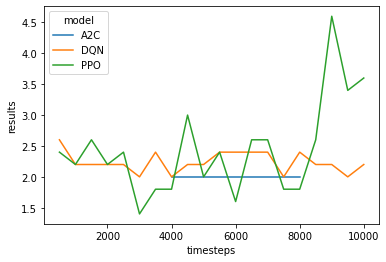

In [10]:
A2C_df = npz_to_dataframe(np.load(r'Breakout_model\Training_evaluation_npz\A2C\evaluations.npz'))
DQN_df = npz_to_dataframe(np.load(r'Breakout_model\Training_evaluation_npz\DQN\evaluations.npz'))
PPO_df = npz_to_dataframe(np.load(r'Breakout_model\Training_evaluation_npz\PPO\evaluations.npz'))

model_dfs = [A2C_df, DQN_df, PPO_df]

model_names = ['A2C', 'DQN', 'PPO']

compare_trainings(model_dfs, model_names)

# X.0 Bronnen
[3 hour course](https://www.youtube.com/watch?v=Mut_u40Sqz4)<br>
[baseline docummentatie](https://stable-baselines3.readthedocs.io/en/master/)